# English→French Machine Translation

### Problem: Translate English sentences into French using a sequence-to-sequence neural model (LSTM encoder–decoder with attention).

In [ ]:
!pip install -q nltk

In [ ]:
import os
import re
import unicodedata
import random
from pathlib import Path
from collections import Counter

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, LSTMCell, Dense
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!wget -q -O fra-eng.zip http://www.manythings.org/anki/fra-eng.zip
!unzip -o fra-eng.zip -d fra-eng-data
DATA_PATH = "fra-eng-data/fra.txt"
print("Loaded:", DATA_PATH)

Archive:  fra-eng.zip
  inflating: fra-eng-data/_about.txt  
  inflating: fra-eng-data/fra.txt    
Loaded: fra-eng-data/fra.txt


In [ ]:
def normalize_text(s):
    s = s.lower().strip()
    s = unicodedata.normalize("NFKD", s)
    # Keep basic punctuation and letters (including accented)
    s = re.sub(r"[^a-zA-Z0-9À-ÖØ-öø-ÿ'.,!?;:\-() ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [ ]:
pairs = []
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            en, fr = parts[0], parts[1]
            pairs.append((normalize_text(en), normalize_text(fr)))

In [ ]:
MAX_SAMPLES = 50000
if MAX_SAMPLES is not None:
    pairs = pairs[:MAX_SAMPLES]
print("Pairs used:", len(pairs))

Pairs used: 50000


In [ ]:
df = pd.DataFrame(pairs, columns=['en', 'fr'])
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

In [ ]:
df['fr_in'] = df['fr'].apply(lambda s: "<start> " + s)
df['fr_out'] = df['fr'].apply(lambda s: s + " <end>")

In [ ]:
eng_tokenizer = Tokenizer(filters='', oov_token='<oov>')
eng_tokenizer.fit_on_texts(df['en'].tolist())

In [ ]:
fr_tokenizer = Tokenizer(filters='', oov_token='<oov>')
fr_tokenizer.fit_on_texts(df['fr_in'].tolist() + df['fr_out'].tolist())

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1
print("Vocab sizes -> EN:", eng_vocab_size, "FR:", fr_vocab_size)

Vocab sizes -> EN: 9132 FR: 13886


In [ ]:
eng_seq = eng_tokenizer.texts_to_sequences(df['en'].tolist())
fr_in_seq = fr_tokenizer.texts_to_sequences(df['fr_in'].tolist())
fr_out_seq = fr_tokenizer.texts_to_sequences(df['fr_out'].tolist())

In [ ]:
MAX_EN_LEN = min(60, int(np.percentile([len(s) for s in eng_seq], 98)))
MAX_FR_LEN = min(60, int(np.percentile([len(s) for s in fr_in_seq], 98)))
print("Max lengths -> EN:", MAX_EN_LEN, "FR:", MAX_FR_LEN)

Max lengths -> EN: 5 FR: 9


In [ ]:
encoder_input_data = pad_sequences(eng_seq, maxlen=MAX_EN_LEN, padding='post')
decoder_input_data = pad_sequences(fr_in_seq, maxlen=MAX_FR_LEN, padding='post')
decoder_target_data = pad_sequences(fr_out_seq, maxlen=MAX_FR_LEN, padding='post')

In [ ]:
print("Shapes:", encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape)

Shapes: (50000, 5) (50000, 9) (50000, 9)


In [ ]:
RND = 42
X_enc_train, X_enc_temp, X_dec_in_train, X_dec_in_temp, X_dec_out_train, X_dec_out_temp = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.10, random_state=RND)

X_enc_val, X_enc_test, X_dec_in_val, X_dec_in_test, X_dec_out_val, X_dec_out_test = train_test_split(
    X_enc_temp, X_dec_in_temp, X_dec_out_temp, test_size=0.5, random_state=RND)

print("Train:", X_enc_train.shape, "Val:", X_enc_val.shape, "Test:", X_enc_test.shape)

Train: (45000, 5) Val: (2500, 5) Test: (2500, 5)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, enc_outputs, dec_hidden, mask=None):
        # enc_outputs: (batch, enc_time, enc_units)
        # dec_hidden: (batch, dec_units)
        hidden_with_time_axis = tf.expand_dims(dec_hidden, 1)
        score = tf.nn.tanh(self.W1(enc_outputs) + self.W2(hidden_with_time_axis))
        score = self.V(score)  # (batch, enc_time, 1)
        score = tf.squeeze(score, axis=-1)  # (batch, enc_time)

        if mask is not None:
            # mask: True for real tokens -> keep; False for pad
            # For padded positions set very negative score
            neg_inf = -1e9
            mask_cast = tf.cast(mask, score.dtype)
            score = score * mask_cast + (1.0 - mask_cast) * neg_inf

        attn_weights = tf.nn.softmax(score, axis=1)  # (batch, enc_time)
        attn_weights_exp = tf.expand_dims(attn_weights, -1)  # (batch, enc_time, 1)
        context_vector = tf.reduce_sum(attn_weights_exp * enc_outputs, axis=1)  # (batch, enc_units)
        return context_vector, attn_weights

In [ ]:
class DecoderCell(tf.keras.layers.Layer):
    def __init__(self, dec_units, fr_vocab_size, attention_layer, **kwargs):
        super().__init__(**kwargs)
        self.dec_units = dec_units
        self.fr_vocab_size = fr_vocab_size
        self.attention = attention_layer
        self.lstm_cell = LSTMCell(dec_units)
        self.fc = Dense(fr_vocab_size)

        # will be set externally before decoding
        self.enc_outputs = None
        self.enc_mask = None

    @property
    def state_size(self):
        return [self.dec_units, self.dec_units]

    @property
    def output_size(self):
        return self.fr_vocab_size

    def call(self, inputs, states, training=None):
        h, c = states

        # read encoder outputs stored earlier
        enc_outputs = self.enc_outputs
        enc_mask = self.enc_mask

        context_vector, attn_weights = self.attention(enc_outputs, h, mask=enc_mask)

        x_and_context = tf.concat([inputs, context_vector], axis=-1)
        lstm_out, [new_h, new_c] = self.lstm_cell(x_and_context, states=[h, c], training=training)

        logits = self.fc(lstm_out)
        return logits, [new_h, new_c]


In [ ]:
class Seq2SeqRNN(Model):
    def __init__(self, eng_vocab_size, fr_vocab_size, embedding_dim=256, enc_units=256, dec_units=256):
        super().__init__()

        self.enc_emb = Embedding(eng_vocab_size, embedding_dim, mask_zero=True)
        self.encoder = LSTM(enc_units, return_sequences=True, return_state=True)

        self.dec_emb = Embedding(fr_vocab_size, embedding_dim, mask_zero=True)

        self.attention = BahdanauAttention(dec_units)
        self.decoder_cell = DecoderCell(dec_units, fr_vocab_size, attention_layer=self.attention)

        # RNN wrapper for decoding
        self.decoder_rnn = tf.keras.layers.RNN(
            self.decoder_cell,
            return_sequences=True,
            return_state=True
        )

    def call(self, inputs, training=False):
        encoder_inputs, decoder_inputs = inputs

        # ----- Encoder -----
        enc_x = self.enc_emb(encoder_inputs)
        enc_outputs, enc_h, enc_c = self.encoder(enc_x, training=training)

        # Mask for attention
        enc_mask = tf.cast(tf.not_equal(encoder_inputs, 0), tf.bool)

        # ----- Pass encoder outputs & mask into decoder cell -----
        self.decoder_cell.enc_outputs = enc_outputs
        self.decoder_cell.enc_mask = enc_mask

        # ----- Decoder -----
        dec_emb = self.dec_emb(decoder_inputs)

        # Run RNN (does autoregressive decoding inside the cell)
        rnn_out = self.decoder_rnn(
            dec_emb,
            initial_state=[enc_h, enc_c],
            training=training
        )

        dec_outputs = rnn_out[0]  # (batch, dec_time, vocab)
        return dec_outputs


In [ ]:
embedding_dim = 256
enc_units = 256
dec_units = 256

In [ ]:
model = Seq2SeqRNN(eng_vocab_size, fr_vocab_size, embedding_dim, enc_units, dec_units)

# build by calling once
dummy_enc = tf.zeros((2, MAX_EN_LEN), dtype=tf.int32)
dummy_dec = tf.zeros((2, MAX_FR_LEN), dtype=tf.int32)
_ = model((dummy_enc, dummy_dec))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'decoder_cell_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'bahdanau_attention_2' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "seq2_seq_rnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (2, 5, 256)            │     2,337,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ((2, 5, 256), (2,      │       525,312 │
│                                 │ 256), (2, 256))        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (2, 9, 256)            │     3,554,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bahdanau_attention_2            │ ?                      │       131,841 │
│ (BahdanauAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_cell_2 (DecoderCell)    │ ?                      │     4,487,999 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_2 (RNN)                     │ ((2, 9, 13886), (2,    │     4,487,999 │
│                                 │ 256), (2, 256))        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,905,919 (41.60 MB)

 Trainable params: 10,905,919 (41.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def masked_loss(y_true, y_pred):
    # y_true: (batch, dec_time), y_pred: (batch, dec_time, vocab)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss_ = loss_object(y_true, y_pred)  # shape (batch, dec_time)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=masked_loss, run_eagerly=False)

In [ ]:
BATCH_SIZE = 64
BUFFER = 20000

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(((X_enc_train, X_dec_in_train), X_dec_out_train))
train_dataset = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(((X_enc_val, X_dec_in_val), X_dec_out_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('seq2seq_rnn_best.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 5.8052

704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - loss: 5.8040 - val_loss: 4.0372
Epoch 2/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.6592

704/704 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - loss: 3.6587 - val_loss: 3.3225
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8750

704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - loss: 2.8748 - val_loss: 2.8712
Epoch 4/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.3279

704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - loss: 2.3277 - val_loss: 2.5629
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.8857

704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - loss: 1.8856 - val_loss: 2.3609
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.5341

704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - loss: 1.5341 - val_loss: 2.2030
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.2555

704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 1.2555 - val_loss: 2.0983
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.0349

704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - loss: 1.0349 - val_loss: 2.0303
Epoch 9/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.8560

704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 0.8560 - val_loss: 2.0025
Epoch 10/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7225

704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - loss: 0.7225 - val_loss: 1.9703
Epoch 11/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - loss: 0.6109 - val_loss: 1.9721
Epoch 12/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - loss: 0.5329 - val_loss: 1.9771
Epoch 13/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - loss: 0.4706 - val_loss: 1.9862


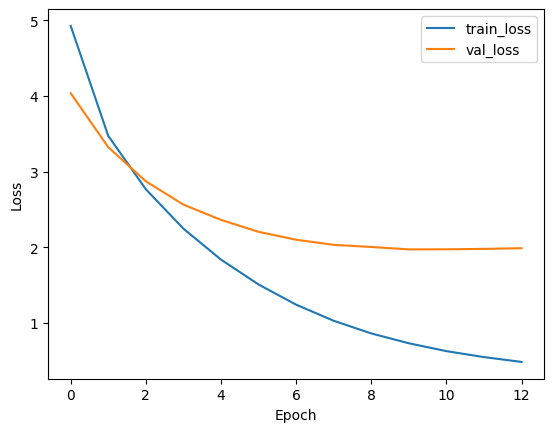

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

In [ ]:
eng_index_word = {v:k for k,v in eng_tokenizer.word_index.items()}
fr_index_word = {v:k for k,v in fr_tokenizer.word_index.items()}
eng_index_word[0] = "<pad>"
fr_index_word[0] = "<pad>"

In [ ]:
start_token = fr_tokenizer.word_index.get('<start>')
end_token = fr_tokenizer.word_index.get('<end>')

In [ ]:
def greedy_translate(sentence, max_len=MAX_FR_LEN):
    s = normalize_text(sentence)
    seq = eng_tokenizer.texts_to_sequences([s])
    enc_inp = pad_sequences(seq, maxlen=MAX_EN_LEN, padding='post')
    enc_x = model.enc_emb(enc_inp)
    enc_outputs, enc_h, enc_c = model.encoder(enc_x, training=False)

    h, c = enc_h, enc_c
    cur_id = start_token
    result_tokens = []

    for _ in range(max_len):
        dec_emb = model.dec_emb(tf.constant([[cur_id]], dtype=tf.int32))  # (1,1,emb)
        dec_emb = tf.squeeze(dec_emb, axis=1)  # (1, emb)

        context_vector, _ = model.attention(enc_outputs, h, mask=tf.cast(tf.not_equal(enc_inp, 0), tf.bool))

        x_and_context = tf.concat([dec_emb, context_vector], axis=-1)
        lstm_cell = model.decoder_cell.lstm_cell
        lstm_out, [h, c] = lstm_cell(x_and_context, states=[h, c], training=False)

        logits = model.decoder_cell.fc(lstm_out)  # (1, vocab)
        next_id = int(tf.argmax(logits, axis=-1).numpy()[0])

        if next_id == end_token or next_id == 0:
            break
        result_tokens.append(fr_index_word.get(next_id, '<unk>'))
        cur_id = next_id

    return " ".join(result_tokens)

In [ ]:
examples = [
    "I love you",
    "How are you?",
    "This is a test sentence.",
    "Where is the nearest restaurant?"
]
for ex in examples:
    print("EN:", ex)
    print("PRED FR:", greedy_translate(ex))
    print("------")

EN: I love you
PRED FR: je vous aime bien.
------
EN: How are you?
PRED FR: comment vas-tu ?
------
EN: This is a test sentence.
PRED FR: ce n'est qu'un de but.
------
EN: Where is the nearest restaurant?
PRED FR: ou est le magasin ?
------
